<a href="https://colab.research.google.com/github/Vsisik/Diplomova-praca/blob/main/colab%20notebooks/CT_Model3DConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Keras-Applications-3D --quiet

In [ ]:
from keras_applications_3d import vgg16, vgg19, resnet, resnet_v2, densenet
import tensorflow as tf

def get_vgg16_3d(height, width, depth):
  input_shape = (height, width, depth, 1)

  vgg_model = vgg16.VGG16(
    include_top=False,
    input_shape=input_shape,
    base_channel=16
  )

  model = tf.keras.Sequential([
      vgg_model,
      tf.keras.layers.Flatten(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ],
      name='vgg16_3d')

  return model

def get_densenet_3d(height, width, depth):
  input_shape = (height, width, depth, 1)

  dense_model = densenet.DenseNet121(
    include_top=False,
    input_shape=input_shape,
    base_channel=16
  )

  model = tf.keras.Sequential([
      dense_model,
      tf.keras.layers.Flatten(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ],
      name='densenet_3d')
  return model

def get_resnet50_3d(height, width, depth):
  input_shape = (height, width, depth, 1)

  resnet_model = resnet.ResNet50(
    include_top=False,
    input_shape=input_shape,
    base_channel=16
  )

  model = tf.keras.Sequential([
      resnet_model,
      tf.keras.layers.Flatten(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ],
      name='resnet50_3d')

  return model

In [ ]:
# model = get_densenet_3d(256, 256, 30)
# model = get_resnet50_3d(256, 256, 20)
# model = get_vgg16_3d(256, 256, 32)
# model.summary()

In [ ]:
#@title **Import libraries and define helping functions**
import os
# import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
# import skimage
# import cv2
import re

from datetime import datetime

import tensorflow as tf

from keras import Model, Input
# from keras.layers import *
from keras import regularizers

from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive',  force_remount=False)

def normalize(data, k=1):
    """
    Fuction normalizes given data to min-max scale

    :param data: Numpy array data
    :return: 0-k scaled numpy array data
    """
    assert type(data) == np.ndarray

    data = k * (data - data.min()) / (data.max() - data.min())
    data = data.astype("float32")
    return data

def allowed_types():
    """
    Function returns list of allowed CT scan series descriptions
    """
    return ['Head  3.0  MPR']


def uniform_depth(data, depth=30, center_pos=3/5, type_='multi'):
    """
    Function uniforms depth of CT scans
    (given size of the body there might be more/less scans)

    -----------------------------------------
    In case of leukoencefalopathy classification:
    Ventricular system is located approx. in 3/5 depth of the scan
    -----------------------------------------

    :param data: numpy array data
    :param depth: number of
    :param center_pos: location of desired object in %
    :type_: single/multi - single=single patient/ multi=multi patients
    :return: uniformed depth in data
    """
    if type_ == 'single':
        data = np.array([data])

    if type(data) == np.ndarray:
        data = data.tolist()


    ct_scans = list()
    for scan in data:
        # Take only middle slices of CT scan (first/last parts have no important information)
        # If CT scan has 71 and desired depth is 30 -> final CT scan = original_scan[20:50]
        center = int(len(scan)*center_pos)
        ct_scans.append(scan[center - (depth // 2): center + (depth // 2)])

    if type_ == 'single':
        return np.array(ct_scans[0])
    return np.array(ct_scans)



def plot_ct_images(data, rows=6, cols=6, start_with=10, show_every=3, block=True):
    fig, ax = plt.subplots(rows, cols, figsize=[8, 8])
    index = start_with
    for i in range(rows):
        for j in range(cols):
            ax[i, j].set_title(f'Scan slice {index}')
            ax[i, j].imshow(data[index], aspect='auto', cmap=plt.cm.bone)
            ax[i, j].axis('off')
            index += show_every
    plt.show(block=block)

def get_model(width, height, depth, type_=1):
    """
    Function creates a model architecture based on given type_ parameter

    Inspiration based on https://keras.io/examples/vision/3D_image_classification/#introduction


    :param width: Width number
    :param height: Height number
    :param depth: Depth number
    :param type_: Type of architecture
    :return: CNN Model
    """

    inputs = Input((height, width, depth, 1))

    ############### TYPE 1 ############################
    if type_ == 1:
      """
      Big CNN
      - Five Convolutional layers
      - Two Pooling layer
      - Medium regularization
      """
      regularizer = regularizers.L2(0.001)
      x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=regularizer)(inputs)
      x = tf.keras.layers.BatchNormalization()(x)

      x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=regularizer)(x)
      x = tf.keras.layers.MaxPooling3D(pool_size=2, padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)

      x = tf.keras.layers.Conv3D(filters=128, kernel_size=3, activation="relu", kernel_regularizer=regularizer)(x)
      x = tf.keras.layers.BatchNormalization()(x)

      x = tf.keras.layers.Conv3D(filters=128, kernel_size=3, activation="relu", kernel_regularizer=regularizer)(x)
      x = tf.keras.layers.MaxPooling3D(pool_size=2, padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)

      x = tf.keras.layers.Conv3D(filters=256, kernel_size=3, activation="relu", kernel_regularizer=regularizer)(x)
      x = tf.keras.layers.MaxPooling3D(pool_size=2, padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)

      x = tf.keras.layers.GlobalAveragePooling3D()(x)
      x = tf.keras.layers.Dense(units=512, activation="relu")(x)
      x = tf.keras.layers.Dropout(0.3)(x)

      outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

      model = Model(inputs, outputs, name='CT_Model')

    ############### TYPE 2 ############################
    if type_ == 2:
      raise ValueError('Erased model! Use another one!')

    ############### TYPE 3 ############################
    if type_ == 3:
      """
      Small CNN
      - Two Convolutional layers
      - Two Pooling layer
      - Medium regularization
      """
      regularizer = regularizers.L2(0.001)

      x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=regularizer)(inputs)
      x = tf.keras.layers.MaxPooling3D(pool_size=2)(x)
      x = tf.keras.layers.BatchNormalization()(x)

      x = tf.keras.layers.Conv3D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=regularizer)(x)
      x = tf.keras.layers.MaxPooling3D(pool_size=2, padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)

      x = tf.keras.layers.GlobalAveragePooling3D()(x)
      x = tf.keras.layers.Dense(units=256, activation='relu')(x)
      x = tf.keras.layers.Dropout(0.3)(x)

      outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

      model = Model(inputs, outputs, name='CT_Model')

    ############### TYPE 4 ############################
    if type_ == 4:
      """
      Medium CNN
      - Three Convolutional layers
      - Two pooling layers
      - High regularization
      """
      regularizer = regularizers.L2(0.01)

      x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=regularizer)(inputs)
      x = tf.keras.layers.BatchNormalization()(x)

      x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=regularizer)(x)
      x = tf.keras.layers.MaxPooling3D(pool_size=2)(x)
      x = tf.keras.layers.BatchNormalization()(x)

      x = tf.keras.layers.Conv3D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=regularizer)(x)
      x = tf.keras.layers.MaxPooling3D(pool_size=2)(x)
      x = tf.keras.layers.BatchNormalization()(x)

      x = tf.keras.layers.GlobalAveragePooling3D()(x)
      x = tf.keras.layers.Dense(units=512, activation='relu')(x)
      x = tf.keras.layers.Dropout(0.5)(x)

      outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

      model = Model(inputs, outputs, name='CT_Model')

    # else:
    #   raise ValueError('Model type:' + str(type_) + 'is not implemented!')

    return model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Load data from directory**

Our CT scans data are already preprocessed and saved as numpy binary files in *.zip*.

We need to unzip them into temporary (local) drive.

Here we define paths to retrieve data from Google Drive as well as temporary folders:

In [ ]:
preprocess_type = '4' # @param {type:"string"}

In [ ]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
r_neg = re.compile('data_neg_TYPE*')
data_neg_path = list(filter(r_neg.match, os.listdir('/tmp')))

if len(data_neg_path) == 0:
  source_pos_path = '/content/drive/MyDrive/Diplomová\ \práca/CT_Dataset/data_pos_' + preprocess_type + '_large.zip'
  source_neg_path = '/content/drive/MyDrive/Diplomová\ \práca/CT_Dataset/data_neg_' + preprocess_type + '_large.zip'

  data_pos_path = '/tmp/data_pos_TYPE' + preprocess_type
  data_neg_path = '/tmp/data_neg_TYPE' + preprocess_type

  # !unzip $source_pos_path -d $data_pos_path
  # !unzip $source_neg_path -d $data_neg_path

  !7za x -o$data_pos_path $source_pos_path
  !7za x -o$data_neg_path $source_neg_path

else:
  data_neg_path = '/tmp/' + data_neg_path[0]

  pos_pattern = '(data_pos_TYPE)([0-9])'
  name, preprocess_type = re.findall(pos_pattern, "".join(os.listdir('/tmp')))[0]
  data_pos_path = '/tmp/' + name + preprocess_type

pos_file = data_pos_path + '/' + os.listdir(data_pos_path)[0]
neg_file = data_neg_path + '/' + os.listdir(data_neg_path)[0]

We use numpy function *load* to retrieve arrays stored into *.npy* format.

In [ ]:
# %%script False
if preprocess_type in ['4', '5', '6']:
  pos_file = f"/tmp/data_pos_TYPE{preprocess_type}/tmp/data_pos_{preprocess_type}_large.npy"
  neg_file = f"/tmp/data_neg_TYPE{preprocess_type}/tmp/data_neg_{preprocess_type}_large.npy"

In [ ]:
data_pos = np.load(pos_file, allow_pickle=True).astype(np.float32)
data_neg = np.load(neg_file, allow_pickle=True).astype(np.float32)

# Limit number of scans
limit = None # 100
data_pos = data_pos[:limit]
data_neg = data_neg[:limit]

### **Data description**
Our loaded data are in form of tensor with 4 dimensions:

First one is the number of samples

Second one is depth of each CT scan (3D image)

Third and fourth ones are width and height of single layer CT scan (2D image)

In [ ]:
data_pos.shape

(633, 40, 256, 256)

Total amount of samples (positives + negatives)

In [ ]:
len(data_pos) + len(data_neg)

1244

Pixel max value (should be less than 100) and min value (should be 0)

In [ ]:
data_pos.max()

1.0

In [ ]:
data_pos.min()

0.0

All pixels are saved as float64

In [ ]:
data_pos.dtype

dtype('float32')

### **Data plot**

Here we can see what our data look like!

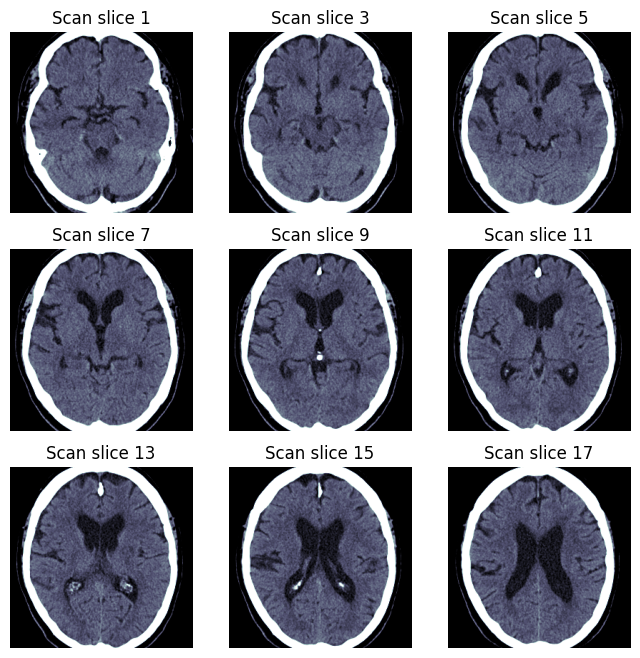

In [ ]:
indx = np.random.randint(0, len(data_pos) - 1)
plot_ct_images(data_pos[indx], rows=3, cols=3, start_with=1, show_every=2)

## **Data prepare**

In this step positive and negative data are conctenate into new variable called "X"

Afterwards we use data augmentation

These data are given targets (1 - positive | 0 - negative) in new variable "y"

In following step the data are split into sets of training data, validation data and test data.

### **Concat data**

Conctenate positive and negative data together and assign them targets 0 and 1

In [ ]:
target_positive = np.ones((len(data_pos),), dtype='int')
target_negative = np.zeros((len(data_neg),), dtype='int')

X = np.concatenate((data_pos, data_neg), axis=0)
y = np.concatenate((target_positive, target_negative), axis=0)

del data_pos, data_neg, target_positive, target_negative

### Resize

In [ ]:
# import cv2
width, height = 224, 224

res = np.zeros(shape=(len(X), len(X[0]), height, width, 1), dtype=np.float32)

for idx in range(len(X)):
  for idx2 in range(len(X[idx])):
    # res[idx, idx2] = cv2.resize(X[idx, idx2], (width, height), interpolation=cv2.INTER_CUBIC)
    res[idx, idx2] = tf.image.resize(np.expand_dims(X[idx, idx2], axis=-1), size=(height, width))

In [ ]:
X = res
del res

In [ ]:
X.shape

(1244, 40, 224, 224, 1)

### **Experiment prepare**

In [ ]:
if False:
  # Crop 3D image
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      X[i, j] = cv2.erode(X[i, j, :, :], (25, 25))

  X = X[:, :-10, 50:114, 32:96]

In [ ]:
if False:
  i = 30
  tst = X[np.random.randint(0, len(X) - 1)]
  tst = np.array([cv2.erode(tst[ind], (i, i)) for ind in range(len(tst))])
  plot_ct_images(tst, rows=3, cols=3, start_with=1, show_every=1)

### **Normalize**

Normalize data between range 0 and 1

In [ ]:
X = X.astype(np.float32)
X = X/X.max()
print('Max value:', X.max())
print('Min value:', X.min())

Max value: 1.0
Min value: 0.0


### **Reshape**

First we need to swap axes of our data into shape (n, height, width, depth, 1) from (n, depth, height, width)
Last number - 1 is set to use the data format convention "channels_last".

Since our data is in grayscale we use 1 instead of 3 (RGB channels).


In [ ]:
n, depth, height, width, channels = X.shape
# X = X.reshape((n, height, width, depth, 1))

# Change from (n, depth, height, width) to (n, height, width, depth)
X = X.swapaxes(1, 3)

# Rotate 90
X = X.swapaxes(1, 2)

# Add channel as last dimension
# X = np.expand_dims(X, axis=-1)
print('Width:\t', width)
print('Height:\t', height)
print('Depth:\t', depth)
print('N:\t', n)

Width:	 224
Height:	 224
Depth:	 40
N:	 1244


#### Final shape

Let's see the final shape of our data

In [ ]:
X.shape

(1244, 224, 224, 40, 1)

### **Split data**

Split data into train, validation and test subsets

In [ ]:
x_train, x_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_rem, y_rem, test_size=0.5, shuffle=True)
del x_rem, y_rem

Let's see how many samples are in each set

In [ ]:
print('Training set:\t', len(x_train))
print('Validation set:\t', len(x_val))
print('Test set:\t', len(x_test))

Training set:	 995
Validation set:	 124
Test set:	 125


### **Data augmentation**

CNN model's are very data hungry so in order to generalize model's accuracy we use data augmentation for 3D images.

https://www.kaggle.com/code/donkeys/3d-convnet-with-3d-augmentations/notebook

In [ ]:
import scipy as sp

def x_flip(data):
  if np.random.randint(1,100) > 50:
      # print(data.shape) == (128, 128, 30, 1)
    flipped = data[:, ::-1, :]
  else:
    flipped = data
  return flipped

def rotate(data, max_angle=15):
  if np.random.randint(1,100) > 50:
    return data

  # img_rot = np.zeros(data.shape)
  angle = np.random.uniform(-max_angle, max_angle)

  # img_rot = sp.ndimage.interpolation.rotate(data, angle, mode='nearest')
  img_rot = sp.ndimage.rotate(data, angle, reshape=False)

  return img_rot.reshape(data.shape)



# @tf.function
def train_preprocessing(data, label):
  """
  Using in data augmentation
  """
  data = rotate(data)
  data = x_flip(data)
  data = data.astype(np.float32)

  return data, label

In [ ]:
del X, y

In [ ]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))

batch_size = 4
train_dataset = (train_loader.map(
    lambda x, y: tf.numpy_function(
          train_preprocessing, [x, y], [tf.float32, tf.int64])
        ).batch(batch_size).prefetch(1))

In [ ]:
# del x_train, y_train

In [ ]:
# valid_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [ ]:
# del x_val, y_val

#### Plot augmented data

In [ ]:
aug_data, labels = list(train_dataset.take(1))[0]
aug_data = aug_data.numpy()
aug_data.shape

(4, 224, 224, 40, 1)

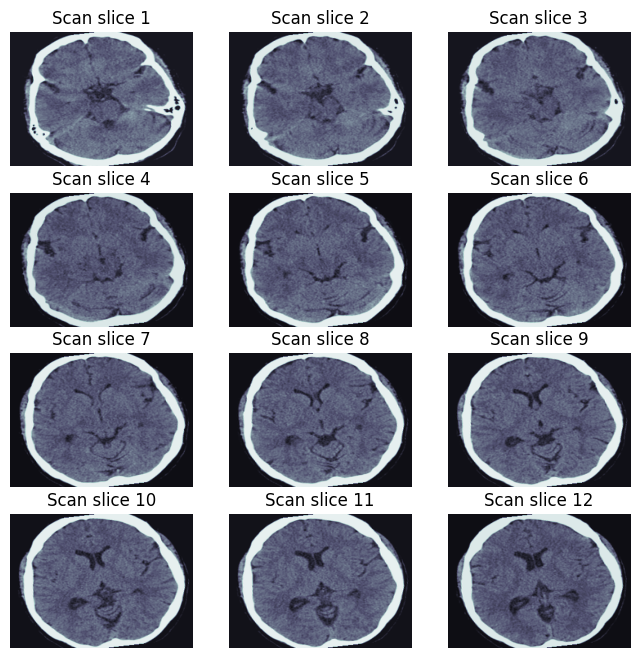

In [ ]:
indx = np.random.randint(0, len(aug_data))
plot_ct_images(aug_data[indx].T[0].swapaxes(1, 2), rows=4, cols=3, start_with=1, show_every=1)

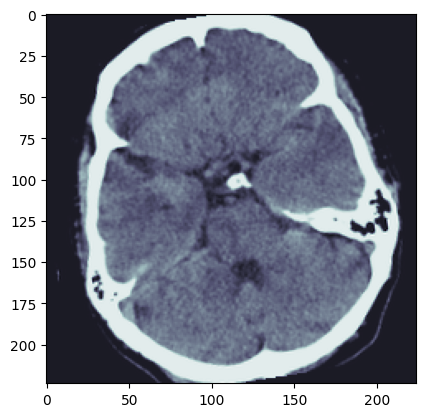

In [ ]:
plt.imshow(aug_data[indx][:, :, 0], cmap="bone")

## **Model training**

In this section we define our model and start training it.

### **Model selection**

We use "model_type" variable to obtain model from section "helping functions" where we defined some CNN architectures for models in the beginning.

In [ ]:
model_type = 3

Here is described each layer of our chosen model:

In [ ]:
model = get_model(height, width, depth, type_=model_type)
# model.summary()

In [ ]:
# script False
model_type = 'resnet50'
model = get_resnet50_3d(height, width, depth)

# model_type = 'vgg'
# model = get_vgg16_3d(height, width, depth)

# model_type = 'densenet'
# model = get_densenet_3d(height, width, depth)
model.summary()

Model: "resnet50_3d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50_3d (Functional)    (None, 7, 7, 2, 512)      2918688   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 batch_normalization_2 (Bat  (None, 50176)             200704    
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 512)               25690624  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                       

In [ ]:
if False:
  tf.keras.utils.plot_model(model,
                            show_shapes=False,
                            show_layer_names=False,
                            # rankdir='LR', # show horizontaly
                            )

#### **Training parameters**

Here we define number of epochs, learning rate, callbacks, etc.

In [ ]:
epochs = 50
batch_size = 8


initial_learning_rate = 1e-5
final_learning_rate = initial_learning_rate / 10

learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
# steps_per_epoch = int(len(x_train)/batch_size)
steps_per_epoch = int(len(train_loader)/ batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                  initial_learning_rate=initial_learning_rate,
                  decay_steps=steps_per_epoch,
                  decay_rate=learning_rate_decay_factor,
                  staircase=True,
                  )
run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom=True)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"),
             tf.keras.metrics.Precision(name="precision"),
             tf.keras.metrics.Recall(name="recall"),
             # tf.keras.metrics.F1Score(name="f1"),
             ],
)

#### **Callbacks**

Basic callbacks to save our model (best only) and to stop early (if validation accuracy is not increasing)

We can add *TensorBoard* callback to log each epoch accuracy, loss, fit parameters (learning rate) etc.

In [ ]:
model_drive_path = f"/content/drive/MyDrive/Diplomová práca/Models/CT_scan_model_type3d_{model_type}.h5"

monitor_param = "val_loss"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_drive_path, save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor=monitor_param, patience=10)
rlronp_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor_param, factor=0.8, patience=2, min_lr=0.00001, verbose=1)

lr_schedule_cb = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)


tensorboard_main_logdir = f"/content/drive/MyDrive/Diplomová práca/Models/logs/scalars/0{preprocess_type}"
logdir = tensorboard_main_logdir + f"/CT_scan_model_type3d_{model_type}_processing_type{preprocess_type}_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=logdir)

csv_logdir = f"/content/drive/MyDrive/Diplomová práca/Models/csv_logs/0{preprocess_type}/CT_scan_model_type3d_{model_type}_{datetime.now().strftime('%Y%m%d-%H%M%S')}.log"
csv_logger_cb = tf.keras.callbacks.CSVLogger(filename=csv_logdir, separator=',', append=True)

### **Model fit**

After all the steps we can finally train our neural network!

In [ ]:
history = model.fit(
        train_dataset,
        # x_train, y_train,
        # aug.flow(x_train, y_train, batch_size=16),
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        verbose=1,
        callbacks=[
            checkpoint_cb,
            early_stopping_cb,
            tensorboard_cb,
            csv_logger_cb,
            # rlronp_cb,
            lr_schedule_cb
                   ])

Epoch 1/50
249/249 [==============================] - ETA: 0s - loss: 0.8969 - binary_accuracy: 0.6080 - precision: 0.6036 - recall: 0.7068

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


249/249 [==============================] - 183s 585ms/step - loss: 0.8969 - binary_accuracy: 0.6080 - precision: 0.6036 - recall: 0.7068 - val_loss: 2.5207 - val_binary_accuracy: 0.5403 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 9.1201e-06
Epoch 2/50
249/249 [==============================] - 136s 545ms/step - loss: 0.7954 - binary_accuracy: 0.6482 - precision: 0.6430 - recall: 0.7204 - val_loss: 2.5451 - val_binary_accuracy: 0.5403 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 8.3176e-06
Epoch 3/50
249/249 [==============================] - 148s 593ms/step - loss: 0.8378 - binary_accuracy: 0.6432 - precision: 0.6444 - recall: 0.6932 - val_loss: 0.7060 - val_binary_accuracy: 0.6774 - val_precision: 0.7297 - val_recall: 0.4737 - lr: 7.5858e-06
Epoch 4/50
249/249 [==============================] - 137s 549ms/step - loss: 0.7730 - binary_accuracy: 0.6583 - precision: 0.6560 - recall: 0.7146 - val_loss: 0.6881 - val_binary_accuracy: 0.6935 - val_precision: 0.67

In order to recognized best model trained so far from all saved models we need to rename default placeholder name of saved .h5 file to new one with val_acc number at the end of the title

In [ ]:
val_acc_str = str(round(max(history.history['val_binary_accuracy']), 4)).replace('.', '')
model_path = f"/content/drive/MyDrive/Diplomová práca/Models/CT_scan_model_type{model_type}_val_acc{val_acc_str}_processing_type{preprocess_type}.h5"
os.rename(model_drive_path, model_path)

model_path

'/content/drive/MyDrive/Diplomová práca/Models/CT_scan_model_typeresnet50_val_acc07823_processing_type6.h5'

Best validation accuracy from training of our model

In [ ]:
max(history.history['val_binary_accuracy'])

0.7822580933570862

#### **History plot**

Using *matplotlib* library we can plot history of our model training.

First plot is comparison between "training loss" and "validation loss" per epoch.

In second one we compare binary accuracy

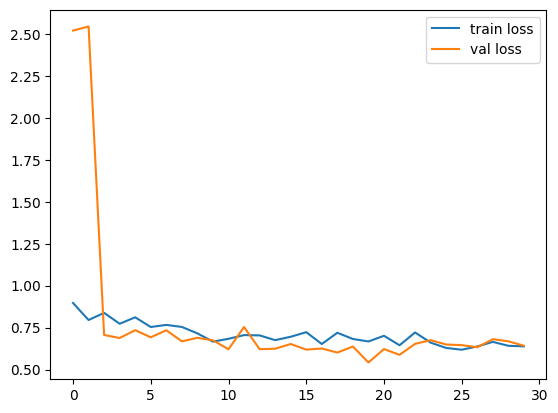

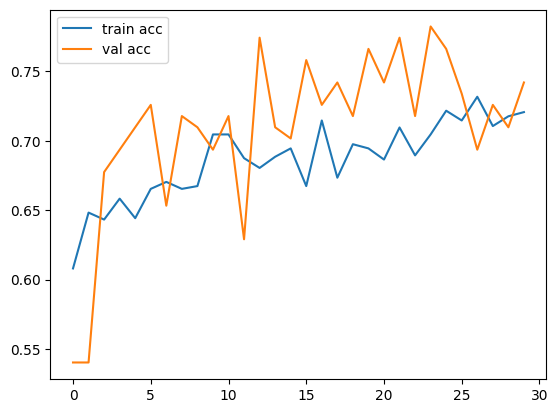

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title(f'{model_type} training - loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
# plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['binary_accuracy'], label='train acc')
plt.plot(history.history['val_binary_accuracy'], label='val acc')
plt.legend()
plt.title(f'{model_type} training - accuracy')
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.show()

# plt.savefig('AccVal_acc')

In [ ]:
tensorboard_show = True

if tensorboard_show:
  !pip install tensorrt --quiet
  %load_ext tensorboard
  tnsbrd_path = tensorboard_main_logdir.replace(' ', '\\ \\')
  %tensorboard --logdir $tnsbrd_path

<IPython.core.display.Javascript object>

## **Results**

In this section we'll test our trained model on test data that has never seen before.

Model.predict function generates output predictions for the input samples.
In case of binary classification (positive/negative) we can say all probabilities greater than 0.5 are of class 1 and all others are of class 0.

#### Load best model

In [ ]:
from tensorflow.keras.models import load_model

model = load_model(model_path)

In [ ]:
model.evaluate(x_test, y_test,
               batch_size=4,
               callbacks=[
                   tensorboard_cb,
                   ],
               )[1]

32/32 [==============================] - 3s 58ms/step - loss: 0.4935 - binary_accuracy: 0.7760 - precision: 0.8000 - recall: 0.7213


0.7760000228881836

### Predict results

In [ ]:
y_pred = model.predict(x_test,
                       batch_size=8
                       ).flatten()

16/16 [==============================] - 3s 122ms/step


In [ ]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0

In [ ]:
y_pred

array([0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
       1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
       1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1.,
       1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 1., 1., 0., 0.], dtype=float32)

In [ ]:
y_test

array([0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0])

In [ ]:
# np.count_nonzero returns count elementwise matches for y_pred and y_test arrays
acc = np.count_nonzero(y_pred == y_test) / len(x_test)
print("Accuracy of the model is - " , acc*100 , "%")

Accuracy of the model is -  77.60000000000001 %


In [ ]:
# Same result using tensorflow evaluate function
print("Accuracy of the model is - " , model.evaluate(x_test, y_test, batch_size=4)[1]*100 , "%")

32/32 [==============================] - 1s 45ms/step - loss: 0.4935 - binary_accuracy: 0.7760 - precision: 0.8000 - recall: 0.7213
Accuracy of the model is -  77.60000228881836 %


### Confusion matrix

A confusion matrix is a table that is used to define the performance of a classification algorithm.

In [ ]:
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)
confusion_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[53, 11],
       [17, 44]], dtype=int32)>

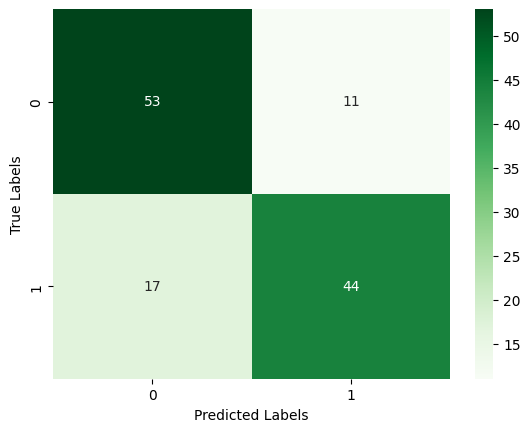

In [ ]:
import seaborn as sns

sns.heatmap(confusion_matrix, annot=True, cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()